In [2]:
import requests
import pandas as pd
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import numpy as np
from sklearn.linear_model import LinearRegression
pd.set_option('display.max_columns', 50)

In [95]:
names = ['Arizona Cardinals', 'Atlanta Falcons', 'Baltimore Ravens', 'Buffalo Bills',
         'Carolina Panthers', 'Chicago Bears', 'Cincinnati Bengals', 'Cleveland Browns',
         'Dallas Cowboys', 'Denver Broncos', 'Detroit Lions', 'Green Bay Packers',
         'Houston Texans', 'Indianapolis Colts', 'Jacksonville Jaguars', 'Kansas City Chiefs',
         'LA Chargers', 'LA Rams', 'Miami Dolphins', 'Minnesota Vikings', 'New York Giants',
         'New York Jets', 'New England Patriots', 'New Orleans Saints', 'Oakland Raiders', 
         'Philadelphia Eagles', 'Pittsburgh Steelers', 'San Francisco 49ers', 
         'Seattle Seahawks', 'Tampa Bay Buccaneers', 'Tennessee Titans', 'Washington Redskins']

In [16]:
def scrape(year):
    
    
    url_start = 'http://www.espn.com/nfl/statistics/team/_/stat/'
    df = pd.read_html(url_start+ 'total/year/' + str(year))[0]
    df.columns = df.iloc[0]
    df = df.drop([0])
    df = df.drop(columns=['RK'])
    df['Year'] = year
    new_names = [(i,'O_' + i ) for i in df.iloc[:, 1:-1].columns.values]
    df.rename(columns = dict(new_names), inplace=True)
    
    df_de = pd.read_html(url_start + 'total/position/defense/year/'+ str(year))[0]
    df_de.columns = df_de.iloc[0]
    df_de = df_de.drop([0])
    df_de = df_de.drop(columns=['RK'])
    new_names = [(i,'D_' + i ) for i in df_de.iloc[:, 1:-1].columns.values]
    df_de.rename(columns = dict(new_names), inplace=True)
    
    df_ds = pd.read_html(url_start + 'defense/year/' + str(year))[0]
    df_ds.columns = df_ds.iloc[1]
    df_ds = df_ds.drop([0,1])
    df_ds = df_ds.drop(columns=['RK'])
    df_ds.head()
    
    df_da = pd.read_html(url_start + 'defense/position/defense/year/' + str(year))[0]
    df_da.columns = df_da.iloc[1]
    df_da = df_da.drop([0,1])
    df_da = df_da.drop(columns=['RK'])
    new_names = [(i, i + '_A') for i in df_da.iloc[:, 1:].columns.values]
    df_da.rename(columns = dict(new_names), inplace=True)
    df_da.head()

    dfs = [df, df_de, df_ds, df_da]
    df_ready = reduce(lambda left,right: pd.merge(left,right,on='TEAM'), dfs)
    df_ready = df_ready.sort_values(by=['TEAM'])
    df_ready['NAME'] = [i.split(' ')[-1] for i in names]
    
    dfs = pd.read_html('http://www.espn.com/nfl/standings/_/season/'+str(year)+'/group/league')
    df_con = pd.concat([dfs[1] , dfs[3]], axis=1)
    df_con['NAME'] = [i.split(' ')[-1] for i in df_con[0]]
    df_con.drop(columns = [0, 'HOME', 'AWAY', 'DIV', 'CONF', 'PF', 'PA',
                           'DIFF', 'STRK'], inplace = True)
    
    df_final = pd.merge(df_con, df_ready, how='outer', on='NAME')
    return df_final

In [21]:
def combine_scrape(start_year, end_year):
    years = list(range(start_year, end_year+1))
    combined_df = pd.DataFrame()
    
    for year in years:
        temp_df = scrape(year)
        combined_df = combined_df.append(temp_df)
        
    combined_df = combined_df.reset_index(drop=True)
    return combined_df

In [22]:
df = combine_scrape(2002, 2018)

In [145]:
df.head()

,W,L,T,PCT,NAME,TEAM,O_YDS,O_YDS/G,O_PASS,O_P YDS/G,O_RUSH,O_R YDS/G,O_PTS,O_PTS/G,Year,D_YDS,D_YDS/G,D_PASS,D_P YDS/G,D_RUSH,D_R YDS/G,D_PTS,PTS/G,SOLO,AST,TOTAL,SACK,YDSL,PD,INT,YDS,LONG,TD_INT,FF,REC,TD_FUM,SOLO_A,AST_A,TOTAL_A,SACK_A,YDSL_A,PD_A,INT_A,YDS_A,LONG_A,TD_INT_A,FF_A,REC_A,TD_FUM_A
0,12.0,4.0,0.0,0.750,Eagles,Philadelphia,5604.0,350.3,3384.0,211.5,2220.0,138.8,415.0,25.9,2002,4754.0,297.1,3094.0,193.4,1660.0,103.8,241.0,15.1,792.0,220.0,1012.0,56.0,348.0,230.0,15.0,193.0,80.0,2.0,29.0,22.0,1.0,826.0,305.0,1131.0,36.0,222.0,230.0,11.0,86.0,35.0,0.0,21.0,13.0,1.0
1,12.0,4.0,0.0,0.750,Packers,Green Bay,5560.0,347.5,3627.0,226.7,1933.0,120.8,398.0,24.9,2002,4985.0,311.6,2987.0,186.7,1998.0,124.9,328.0,20.5,798.0,307.0,1105.0,43.0,241.0,244.0,24.0,516.0,89.0,4.0,22.0,21.0,0.0,883.0,362.0,1245.0,27.0,196.0,219.0,16.0,327.0,65.0,0.0,15.0,12.0,1.0
2,12.0,4.0,0.0,0.750,Buccaneers,Tampa Bay,5002.0,312.6,3445.0,215.3,1557.0,97.3,346.0,21.6,2002,4044.0,252.8,2490.0,155.6,1554.0,97.1,196.0,12.3,788.0,223.0,1011.0,43.0,295.0,251.0,31.0,494.0,97.0,4.0,18.0,7.0,1.0,831.0,314.0,1145.0,41.0,220.0,219.0,10.0,143.0,51.0,3.0,21.0,11.0,0.0
3,11.0,5.0,0.0,0.688,Titans,Tennessee,5272.0,329.5,3320.0,207.5,1952.0,122.0,367.0,22.9,2002,4964.0,310.3,3540.0,221.3,1424.0,89.0,324.0,20.3,778.0,214.0,992.0,40.0,213.0,223.0,18.0,198.0,32.0,3.0,15.0,11.0,1.0,851.0,224.0,1075.0,21.0,121.0,194.0,15.0,179.0,82.0,2.0,11.0,10.0,0.0
4,11.0,5.0,0.0,0.688,Raiders,Oakland,6237.0,389.8,4475.0,279.7,1762.0,110.1,450.0,28.1,2002,4979.0,311.2,3526.0,220.4,1453.0,90.8,304.0,19.0,827.0,186.0,1013.0,43.0,261.0,224.0,21.0,347.0,98.0,3.0,11.0,10.0,0.0,907.0,270.0,1177.0,36.0,214.0,201.0,10.0,226.0,84.0,1.0,17.0,9.0,0.0


In [251]:
cols = []
count = 1
for column in df1.columns:
    cols.append(column)



In [138]:
df[cols] = df[cols].astype(float)
df['Year'] = df['Year'].astype(int)

In [133]:
df.rename(columns={'TD_1': 'TD_INT',
                  'TD_2': 'TD_FUM',
                  'TD_A_1': 'TD_INT_A',
                  'TD_A_2': 'TD_FUM_A'},
         inplace = True)

In [ ]:
df.to_csv('df.csv')

In [3]:
df1 = pd.read_csv('df.csv')

FileNotFoundError: File b'df.csv' does not exist

In [281]:
df1 = df1.drop(columns=['Unnamed: 0'])

In [282]:
df1.head()

,W,L,T,PCT,NAME,TEAM,O_YDS,O_YDS/G,O_PASS,O_P YDS/G,O_RUSH,O_R YDS/G,O_PTS,O_PTS/G,Year,D_YDS,D_YDS/G,D_PASS,D_P YDS/G,D_RUSH,D_R YDS/G,D_PTS,PTS/G,SOLO,AST,TOTAL,SACK,YDSL,PD,INT,YDS,LONG,TD_INT,FF,REC,TD_FUM,SOLO_A,AST_A,TOTAL_A,SACK_A,YDSL_A,PD_A,INT_A,YDS_A,LONG_A,TD_INT_A,FF_A,REC_A,TD_FUM_A
0,12.0,4.0,0.0,0.750,Eagles,Philadelphia,5604.0,350.3,3384.0,211.5,2220.0,138.8,415.0,25.9,2002,4754.0,297.1,3094.0,193.4,1660.0,103.8,241.0,15.1,792.0,220.0,1012.0,56.0,348.0,230.0,15.0,193.0,80.0,2.0,29.0,22.0,1.0,826.0,305.0,1131.0,36.0,222.0,230.0,11.0,86.0,35.0,0.0,21.0,13.0,1.0
1,12.0,4.0,0.0,0.750,Packers,Green Bay,5560.0,347.5,3627.0,226.7,1933.0,120.8,398.0,24.9,2002,4985.0,311.6,2987.0,186.7,1998.0,124.9,328.0,20.5,798.0,307.0,1105.0,43.0,241.0,244.0,24.0,516.0,89.0,4.0,22.0,21.0,0.0,883.0,362.0,1245.0,27.0,196.0,219.0,16.0,327.0,65.0,0.0,15.0,12.0,1.0
2,12.0,4.0,0.0,0.750,Buccaneers,Tampa Bay,5002.0,312.6,3445.0,215.3,1557.0,97.3,346.0,21.6,2002,4044.0,252.8,2490.0,155.6,1554.0,97.1,196.0,12.3,788.0,223.0,1011.0,43.0,295.0,251.0,31.0,494.0,97.0,4.0,18.0,7.0,1.0,831.0,314.0,1145.0,41.0,220.0,219.0,10.0,143.0,51.0,3.0,21.0,11.0,0.0
3,11.0,5.0,0.0,0.688,Titans,Tennessee,5272.0,329.5,3320.0,207.5,1952.0,122.0,367.0,22.9,2002,4964.0,310.3,3540.0,221.3,1424.0,89.0,324.0,20.3,778.0,214.0,992.0,40.0,213.0,223.0,18.0,198.0,32.0,3.0,15.0,11.0,1.0,851.0,224.0,1075.0,21.0,121.0,194.0,15.0,179.0,82.0,2.0,11.0,10.0,0.0
4,11.0,5.0,0.0,0.688,Raiders,Oakland,6237.0,389.8,4475.0,279.7,1762.0,110.1,450.0,28.1,2002,4979.0,311.2,3526.0,220.4,1453.0,90.8,304.0,19.0,827.0,186.0,1013.0,43.0,261.0,224.0,21.0,347.0,98.0,3.0,11.0,10.0,0.0,907.0,270.0,1177.0,36.0,214.0,201.0,10.0,226.0,84.0,1.0,17.0,9.0,0.0


0 0
0 1
0 2
0 3
0 4
0 5
0 6
1 0
1 1
1 2
1 3
1 4
1 5
1 6
2 0
2 1
2 2
2 3
2 4
2 5
2 6
3 0
3 1
3 2
3 3
3 4
3 5
3 6
4 0
4 1
4 2
4 3
4 4
4 5
4 6
5 0
5 1
5 2
5 3
5 4
5 5
5 6
6 0
6 1
6 2
6 3
6 4
6 5
6 6


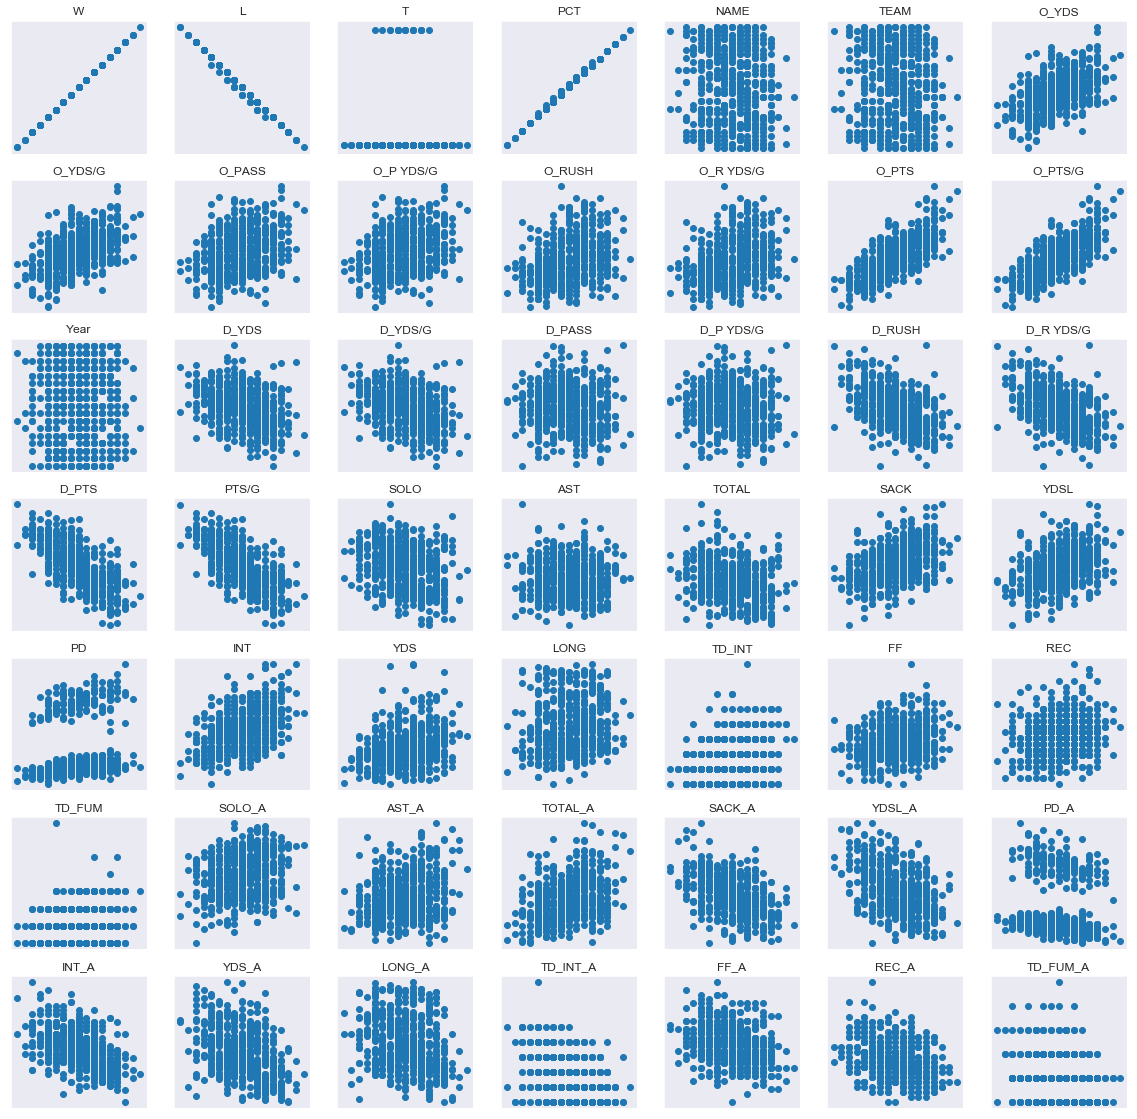

In [283]:
x = df1.W
fig, axs = plt.subplots(7, 7, figsize=(20,20))
r = 0
c = 0
t = 1
for col, row in df1.iteritems(): 

    print(r , c )
    axs[r, c].scatter(x, row)
    axs[r, c].set_title(col)
    axs[r, c].set_xticks([])
    axs[r, c].set_yticks([])
    c += 1
    t += 1
    r = (t-1)//7

    if c > 6:
        c = 0
    


plt.show()

In [1]:
df1.rename(columns={'PTS/G': 'D_PTS/G'}, inplace = True)

NameError: name 'df1' is not defined

In [309]:
y = df1['W']
X = df1[['D_RUSH', 'SACK_A', 'INT_A', 'INT', 'FF', 'FF_A', 'SACK']]

In [354]:
model = ols(formula='y~D_RUSH+SACK_A+INT_A+INT+FF+FF_A+SACK', data=df1).fit()

In [355]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     140.6
Date:                Fri, 19 Apr 2019   Prob (F-statistic):          6.00e-117
Time:                        10:28:36   Log-Likelihood:                -1098.4
No. Observations:                 544   AIC:                             2213.
Df Residuals:                     536   BIC:                             2247.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.4838      0.929     14.509      0.000      11.658      15.309
D_RUSH        -0.0025      0.000     -8.521      0.000      -0.003      -0.002
SACK_A        -0.0862      0.008    -10.876      0.000      -0.102      -0.071
INT_A         -0.2047      0.017    -11.977      0.000      -0.238      -0.171
INT            0.1577      0.017      9.410      0.000       0.125       0.191
FF             0.0538      0.017      3.110      0.002       0.020       0.088
FF_A          -0.0508      0.019     -2.679      0.008      -0.088      -0.014
SACK           0.0782      0.011      6.938      0.000       0.056       0.100
==============================================================================
Omnibus:                        2.529   Durbin-Watson:                   1.506
Prob(Omnibus):                  0.282   Jarque-Bera (JB):                2.423
Skew:                           0.163   Prob(JB):                        0.298
Kurtosis:                       3.033   Cond. No.                     2.18e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

1) sik it learn

2) polynomial , interaction

3) eda

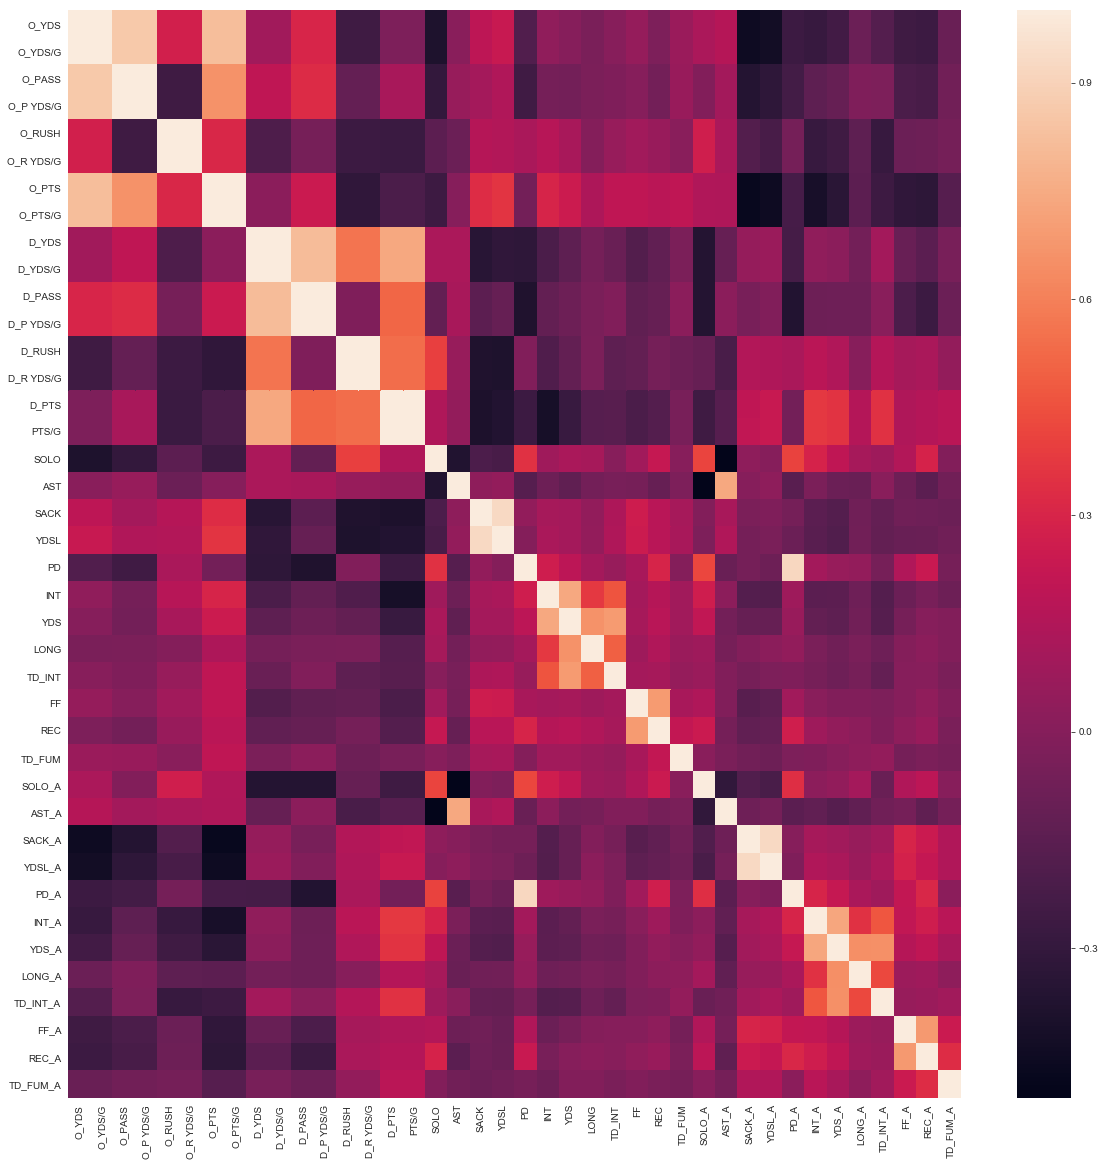

In [312]:
plt.figure(figsize=(20,20))
sns.heatmap(df_plt.corr())


/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


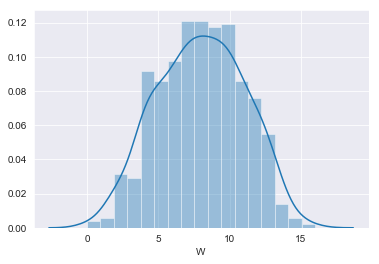

In [289]:
sns.distplot(df1["W"])

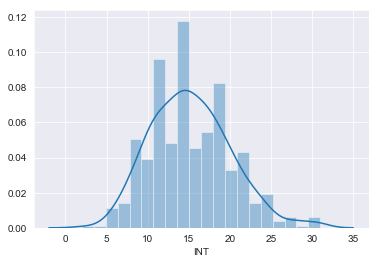

In [290]:
sns.distplot(df1["INT"])

In [291]:
sklearnmodel = LinearRegression(fit_intercept=True).fit(X, y)
r_squared = sklearnmodel.score(X, y)

In [292]:
X.columns

Index(['D_RUSH', 'SACK_A', 'INT_A', 'INT', 'FF', 'FF_A', 'SACK'], dtype='object')

In [293]:
print("Coefficients: ", sklearnmodel.coef_)
print("R2: ", r_squared)

Coefficients:  [-0.00250443 -0.08620344 -0.20470979  0.15767143  0.05375721 -0.05082678
  0.07815854]
R2:  0.6473369404932587


In [294]:
var = ['D_RUSH', 'SACK_A', 'INT_A', 'INT', 'FF', 'FF_A', 'SACK']

In [350]:
predict = sklearnmodel.predict(np.array([[1500, 62, 20, 22, 21, 20, 35]]))

In [351]:
predict

array([6.6050597])

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


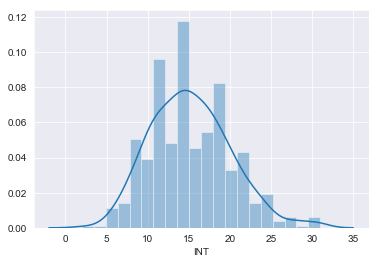

In [297]:
sns.distplot(df1['INT'])

In [298]:
picks = []
for i in range(0, 10000):
    sample = np.random.choice(df1.SACK_A, 50)
    picks.append(sample.mean())

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


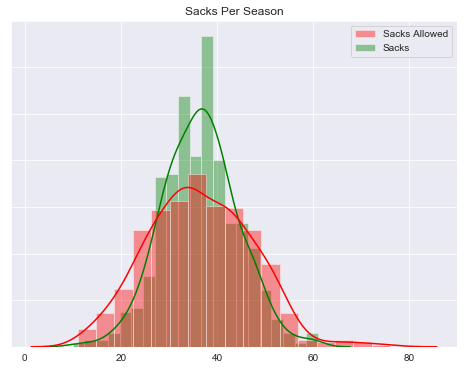

In [324]:
plt.figure(figsize=(8,6))
plt.title('Sacks Per Season', )
sns.set_style(style = 'darkgrid')
sns.distplot(df1.SACK, color='green')

sns.distplot(df1.SACK_A, color='red', axlabel=' ', label='sacks')
# plt.legend('s')
plt.legend(['Sacks Allowed', 'Sacks'])
plt.tick_params(
   axis='y', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')

[]

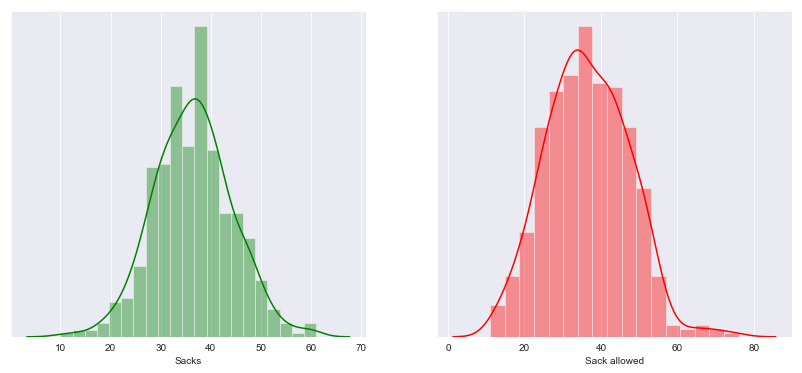

In [325]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
sns.distplot(df1.SACK, color='green', axlabel='Sacks', ax = axs[0])
axs[0].set_yticks([])
sns.distplot(df1.SACK_A, color='red', axlabel='Sack allowed', ax = axs[1])
axs[1].set_yticks([])

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "
/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


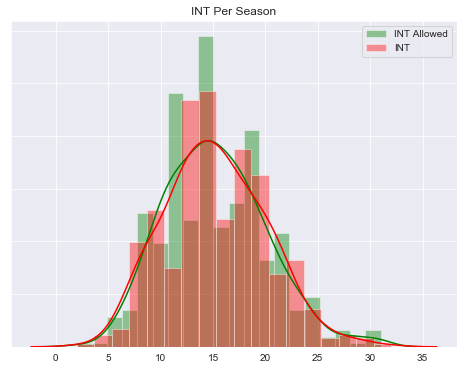

In [323]:
plt.figure(figsize=(8,6))
plt.title('INT Per Season', )
sns.set_style(style = 'darkgrid')
sns.distplot(df1.INT, color='green')
sns.distplot(df1.INT_A, color='red', axlabel=' ')
# plt.legend('s')
plt.legend(['INT Allowed', 'INT'])
plt.tick_params(
   axis='y', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')

[]

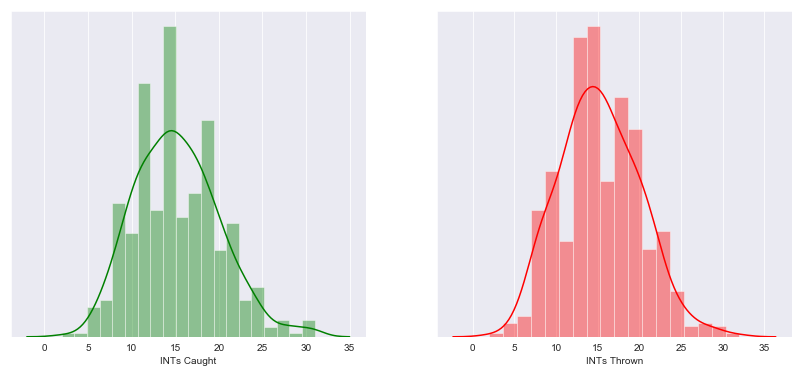

In [314]:
fig, axs = plt.subplots(1,2, figsize=(14,6))
sns.distplot(df1.INT, color='green', axlabel='INTs Caught', ax = axs[0])
axs[0].set_yticks([])
sns.distplot(df1.INT_A, color='red', axlabel='INTs Thrown', ax = axs[1])
axs[1].set_yticks([])

In [303]:
df_plt = df1.drop(columns= ['W', 'L', 'T', 'PCT', 'NAME', 'TEAM', 'Year', 'TOTAL', 'TOTAL_A'])

In [304]:
df_plt.shape

(544, 40)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7


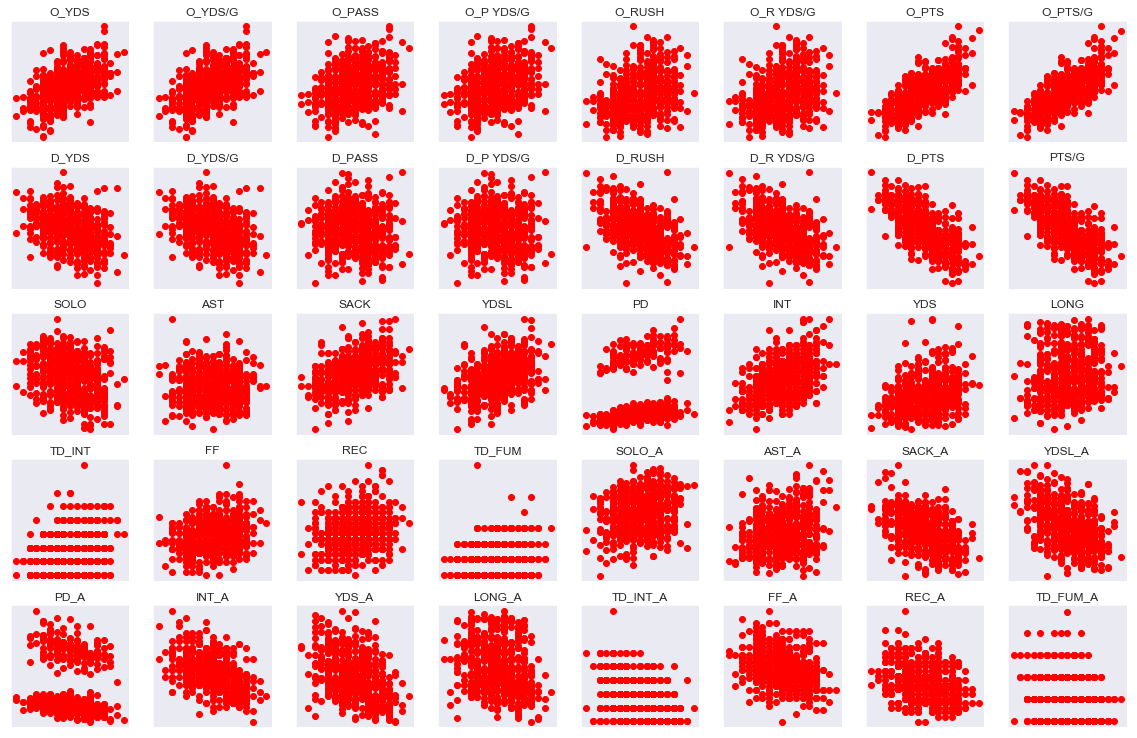

In [353]:
x = df1.W
fig, axs = plt.subplots(5, 8, figsize=(20,13))
r = 0
c = 0
t = 1
for col, row in df_plt.iteritems(): 

    print(r , c)
    axs[r, c].scatter(x, row, color='red')
    axs[r, c].set_title(col)
    axs[r, c].set_xticks([])
    axs[r, c].set_yticks([])
    c += 1
    t += 1
    r = (t-1)//8

    if c > 7:
        c = 0
    
    
#     c +=1 
#     while c < 7:
#         l = 0
# for ax in axs:


plt.show()

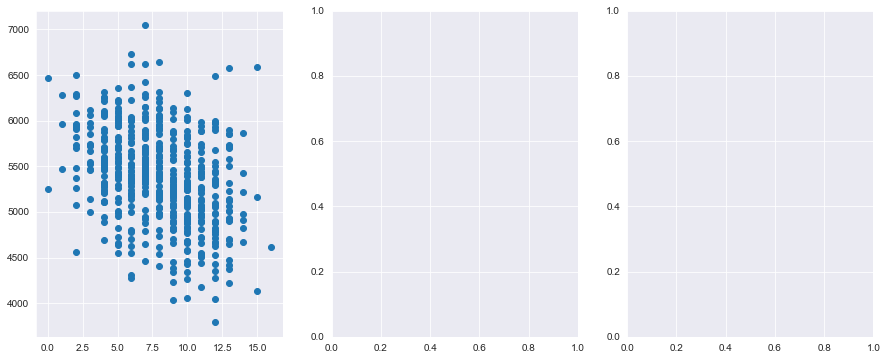

In [337]:
fig, axs = plt.subplots(1, 3, figsize=(15,6))
axs[0].scatter(x, df1['D_YDS'])